# Классификация: Логистическая регрессия для диагностики заболеваний сердца

## Цель работы
- Изучить подход к решению задач машинного обучения: построение базовых моделей (baseline)
- Улучшить навыки разведочного анализа данных (EDA) и подготовки данных
- Научиться строить и анализировать вероятностные модели классификации

## Датасет: Heart Disease (Cleveland)
**Ссылка на описание:** https://archive.ics.uci.edu/dataset/45/heart+disease

**Целевая переменная:** Последняя колонка (class)
- **H** (Healthy/buff) = здоров (класс 0)
- **S1, S2, S3, S4** (Sick) = болен (класс 1)

**Признаки:** 13 атрибутов (возраст, пол, тип боли в груди, давление, холестерин и т.д.)


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, confusion_matrix, classification_report,
                             roc_auc_score, roc_curve, auc)
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import pickle
import json

# Настройки визуализации
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

print("✓ Все библиотеки успешно импортированы")

✓ Все библиотеки успешно импортированы


## Часть 1: Загрузка данных и построение BASELINE модели

In [ ]:
# Загрузка датасета
# Формат: разделение пробелами, пропуск первых 20 строк описания, нет заголовка
df = pd.read_csv("cleve.mod", delim_whitespace=True, skiprows=20, header=None)

# Назначаем имена столбцов на основе описания датасета
column_names = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg',
                'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'diagnosis', 'class']
df.columns = column_names

print(f"Размер датасета: {df.shape}")
print(f"\nТипы данных:\n{df.dtypes}")
print(f"\nПервые строки:")
df.head(10)

Размер датасета: (303, 15)

Типы данных:
age          float64
sex           object
cp            object
trestbps     float64
chol         float64
fbs           object
restecg       object
thalach      float64
exang         object
oldpeak      float64
slope         object
ca            object
thal          object
diagnosis     object
class         object
dtype: object

Первые строки:


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,diagnosis,class
0,63.0,male,angina,145.0,233.0,true,hyp,150.0,fal,2.3,down,0.0,fix,buff,H
1,67.0,male,asympt,160.0,286.0,fal,hyp,108.0,true,1.5,flat,3.0,norm,sick,S2
2,67.0,male,asympt,120.0,229.0,fal,hyp,129.0,true,2.6,flat,2.0,rev,sick,S1
3,37.0,male,notang,130.0,250.0,fal,norm,187.0,fal,3.5,down,0.0,norm,buff,H
4,41.0,fem,abnang,130.0,204.0,fal,hyp,172.0,fal,1.4,up,0.0,norm,buff,H
5,56.0,male,abnang,120.0,236.0,fal,norm,178.0,fal,0.8,up,0.0,norm,buff,H
6,62.0,fem,asympt,140.0,268.0,fal,hyp,160.0,fal,3.6,down,2.0,norm,sick,S3
7,57.0,fem,asympt,120.0,354.0,fal,norm,163.0,true,0.6,up,0.0,norm,buff,H
8,63.0,male,asympt,130.0,254.0,fal,hyp,147.0,fal,1.4,flat,1.0,rev,sick,S2
9,53.0,male,asympt,140.0,203.0,true,hyp,155.0,true,3.1,down,0.0,rev,sick,S1


### Описание полей датасета

Каждая строка соответствует одному пациенту.

| Поле | Описание |
|-----|----------|
| `age` | Возраст пациента (в годах) |
| `sex` | Пол пациента: 0 — женщина, 1 — мужчина |
| `cp` | Тип боли в грудной клетке (chest pain):<br>0 — типичная стенокардия,<br>1 — атипичная стенокардия,<br>2 — неангинозная боль,<br>3 — бессимптомное течение |
| `trestbps` | Артериальное давление в покое (мм рт. ст.) |
| `chol` | Уровень общего холестерина в сыворотке крови (мг/дл) |
| `fbs` | Уровень глюкозы натощак > 6.1 ммоль/л:<br>0 — нет, 1 — да |
| `restecg` | Результаты ЭКГ в покое:<br>0 — норма,<br>1 — нарушения ST‑T,<br>2 — гипертрофия левого желудочка |
| `thalach` | Максимально достигнутая ЧСС |
| `exang` | Стенокардия при нагрузке:<br>0 — нет, 1 — да |
| `oldpeak` | Депрессия сегмента ST при нагрузке |
| `slope` | Наклон сегмента ST при нагрузке |
| `ca` | Количество крупных сосудов (0–3), выявленных при ангиографии |
| `thal` | Результат сцинтиграфии миокарда |
| `class` | Целевой признак:<br>`H` — здоров,<br>`S1–S4` — наличие сердечного заболевания разной степени |

In [ ]:
# Создаём копию для работы
df_baseline = df.copy()

# Преобразуем целевой признак в числовой (H -> 0, S* -> 1)
df_baseline['target'] = (df_baseline['class'] != 'H').astype(int)
#Мы ищем наличие болезни сердца в текстовом формате и преобразуем: 0 - нет болезни (H), 1 - есть болезнь (S1, S2, S3)

# Выбираем только числовые признаки
numeric_cols = df_baseline.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols.remove('target')  # Исключаем целевой признак

print(f"Числовые признаки для baseline: {numeric_cols}")
print(f"\nРаспределение классов:\n{df_baseline['target'].value_counts()}")
print(f"\nПроцент здоровых: {(df_baseline['target']==0).sum()/len(df_baseline)*100:.1f}%")

X_baseline = df_baseline[numeric_cols]
y_baseline = df_baseline['target']

# Проверяем на пропуски
print(f"\nПропуски в X:\n{X_baseline.isnull().sum()}")

# Делим на train/test (80/20)
X_train_bl, X_test_bl, y_train_bl, y_test_bl = train_test_split(
    X_baseline, y_baseline, test_size=0.2, random_state=42, stratify=y_baseline
)

print(f"\nТрейн размер: {X_train_bl.shape}, Тест размер: {X_test_bl.shape}")

Числовые признаки для baseline: ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']

Распределение классов:
target
0    165
1    138
Name: count, dtype: int64

Процент здоровых: 54.5%

Пропуски в X:
age         0
trestbps    0
chol        0
thalach     0
oldpeak     0
dtype: int64

Трейн размер: (242, 5), Тест размер: (61, 5)


In [ ]:
# Обучаем BASELINE модель логистической регрессии
print("=" * 60)
print("BASELINE МОДЕЛЬ: Логистическая регрессия")
print("=" * 60)

model_baseline = LogisticRegression(max_iter=1000, random_state=42)
model_baseline.fit(X_train_bl, y_train_bl)

# Предсказания
y_pred_bl = model_baseline.predict(X_test_bl)
y_pred_proba_bl = model_baseline.predict_proba(X_test_bl)[:, 1]

# Метрики качества
acc_bl = accuracy_score(y_test_bl, y_pred_bl)
prec_bl = precision_score(y_test_bl, y_pred_bl)
rec_bl = recall_score(y_test_bl, y_pred_bl)
f1_bl = f1_score(y_test_bl, y_pred_bl)
roc_auc_bl = roc_auc_score(y_test_bl, y_pred_proba_bl)

print(f"\n📊 РЕЗУЛЬТАТЫ BASELINE:")
print(f"  Accuracy (точность):        {acc_bl:.4f}")
print(f"  Precision (точность):      {prec_bl:.4f}")
print(f"  Recall (чувствительность): {rec_bl:.4f}")
print(f"  F1-score:                  {f1_bl:.4f}")
print(f"  ROC-AUC:                   {roc_auc_bl:.4f}")

# Classification report
print("\n📄 Classification report (детализация по классам):")
print(
    classification_report(
        y_test_bl,
        y_pred_bl,
        target_names=["Здоров (H)", "Болен (S*)"]
    )
)

# Матрица ошибок
cm_bl = confusion_matrix(y_test_bl, y_pred_bl)
print(f"\n📊 Матрица ошибок:\n{cm_bl}")

# Сохраняем baseline метрики для сравнения
baseline_metrics = {
    'accuracy': acc_bl,
    'precision': prec_bl,
    'recall': rec_bl,
    'f1': f1_bl,
    'roc_auc': roc_auc_bl,
    'confusion_matrix': cm_bl.tolist()
}

print("\n✓ Baseline модель сохранена для сравнения")


BASELINE МОДЕЛЬ: Логистическая регрессия

📊 РЕЗУЛЬТАТЫ BASELINE:
  Accuracy (точность):        0.7377
  Precision (точность):      0.7143
  Recall (чувствительность): 0.7143
  F1-score:                  0.7143
  ROC-AUC:                   0.8160

📄 Classification report (детализация по классам):
              precision    recall  f1-score   support

  Здоров (H)       0.76      0.76      0.76        33
  Болен (S*)       0.71      0.71      0.71        28

    accuracy                           0.74        61
   macro avg       0.74      0.74      0.74        61
weighted avg       0.74      0.74      0.74        61


📊 Матрица ошибок:
[[25  8]
 [ 8 20]]

✓ Baseline модель сохранена для сравнения


## Часть 2: Разведочный анализ данных (EDA)

### 2.1 Основные характеристики датасета

In [ ]:
print("=" * 80)
print("📊 РАЗВЕДОЧНЫЙ АНАЛИЗ ДАННЫХ (EDA)")
print("=" * 80)

# Базовая информация
print(f"\n1️⃣ РАЗМЕР И СОСТАВ ДАТАСЕТА")
print(f"   Количество объектов: {df.shape[0]}")
print(f"   Количество признаков: {df.shape[1]}")
print(f"   Общее количество ячеек: {df.shape[0] * df.shape[1]}")

📊 РАЗВЕДОЧНЫЙ АНАЛИЗ ДАННЫХ (EDA)

1️⃣ РАЗМЕР И СОСТАВ ДАТАСЕТА
   Количество объектов: 303
   Количество признаков: 15
   Общее количество ячеек: 4545


In [ ]:

# Информация о типах данных
print(f"\n2️⃣ ТИПЫ ДАННЫХ")
print(f"   Числовых признаков: {df.select_dtypes(include=[np.number]).shape[1]}")
print(f"   Категориальных признаков: {df.select_dtypes(exclude=[np.number]).shape[1]}")

# Пропуски
print(f"\n3️⃣ ПРОПУСКИ В ДАННЫХ")
missing_count = df.isnull().sum()
if missing_count.sum() == 0:
    print("   ✓ Пропусков НЕ обнаружено")
else:
    print(f"   {missing_count.sum()} пропусков найдено:")
    print(missing_count[missing_count > 0])

# Дубликаты
print(f"\n4️⃣ ДУБЛИКАТЫ")
duplicates = df.duplicated().sum()
print(f"   Полные дубликаты: {duplicates}")

# Баланс классов
print(f"\n5️⃣ БАЛАНС ЦЕЛЕВОГО ПРИЗНАКА (class)")
class_dist = df['class'].value_counts()
print(f"   {class_dist}")
print(f"\n   Процентное распределение:")
for cls, count in class_dist.items():
    pct = count / len(df) * 100
    print(f"     {cls}: {pct:.1f}% ({count} объектов)")

# Преобразуем в бинарную классификацию
binary_target = (df['class'] != 'H').astype(int)
print(f"\n   После преобразования в бинарную классификацию:")
print(f"   Здоров (H):  {(binary_target == 0).sum()} ({(binary_target == 0).sum()/len(df)*100:.1f}%)")
print(f"   Болен (S*):  {(binary_target == 1).sum()} ({(binary_target == 1).sum()/len(df)*100:.1f}%)")


2️⃣ ТИПЫ ДАННЫХ
   Числовых признаков: 5
   Категориальных признаков: 10

3️⃣ ПРОПУСКИ В ДАННЫХ
   ✓ Пропусков НЕ обнаружено

4️⃣ ДУБЛИКАТЫ
   Полные дубликаты: 1

5️⃣ БАЛАНС ЦЕЛЕВОГО ПРИЗНАКА (class)
   class
H     165
S1     54
S2     36
S3     35
S4     13
Name: count, dtype: int64

   Процентное распределение:
     H: 54.5% (165 объектов)
     S1: 17.8% (54 объектов)
     S2: 11.9% (36 объектов)
     S3: 11.6% (35 объектов)
     S4: 4.3% (13 объектов)

   После преобразования в бинарную классификацию:
   Здоров (H):  165 (54.5%)
   Болен (S*):  138 (45.5%)


In [ ]:
### 2.2 Семи-точечная статистика (7-point summary)

# Выберем числовые признаки
numeric_features = df.select_dtypes(include=[np.number]).columns.tolist()

# Вычисляем 7-point summary: min, Q1, median, Q3, max, mean, std
summary_stats = pd.DataFrame({
    'Min': df[numeric_features].min(),
    'Q1': df[numeric_features].quantile(0.25),
    'Median': df[numeric_features].median(),
    'Q3': df[numeric_features].quantile(0.75),
    'Max': df[numeric_features].max(),
    'Mean': df[numeric_features].mean(),
    'Std': df[numeric_features].std(),
    'Count': df[numeric_features].count()
})

print("\n📊 7-POINT SUMMARY ЧИСЛОВЫХ ПРИЗНАКОВ:")
print(summary_stats.round(2))


📊 7-POINT SUMMARY ЧИСЛОВЫХ ПРИЗНАКОВ:
            Min     Q1  Median     Q3    Max    Mean    Std  Count
age        29.0   47.5    55.0   61.0   77.0   54.37   9.08    303
trestbps   94.0  120.0   130.0  140.0  200.0  131.62  17.54    303
chol      126.0  211.0   240.0  274.5  564.0  246.26  51.83    303
thalach    71.0  133.5   153.0  166.0  202.0  149.65  22.91    303
oldpeak     0.0    0.0     0.8    1.6    6.2    1.04   1.16    303


## 7‑POINT SUMMARY числовых признаков

Для каждого числового признака рассчитываются:

- **Min** — минимальное значение
- **Q1** — это граница, ниже которой находится 25% пациентов
- **Median** — это середина списка
- **Q3** — это граница, ниже которой 75% пациентов.
- **Max** — максимальное значение
- **Mean** — среднее арифметическое
- **Std** — стандартное отклонение (чем больше отклонение чем больше разброс значений)
- **Count** — количество наблюдений

In [ ]:
### 2.3 Диаграммы размаха (boxplot) и скрипичные диаграммы (violin plot)

# Подготавливаем данные с целевым признаком
df_viz = df.copy()
df_viz['target'] = (df_viz['class'] != 'H').astype(int)
df_viz['target_label'] = df_viz['class'].apply(lambda x: 'Здоров' if x == 'H' else 'Болен')

# Создаём интерактивные диаграммы с Plotly
fig_box = make_subplots(rows=2, cols=3, subplot_titles=numeric_features[:6])
for i, feature in enumerate(numeric_features[:6], 1):
    row = (i - 1) // 3 + 1
    col = (i - 1) % 3 + 1

    for status in ['Здоров', 'Болен']:
        data = df_viz[df_viz['target_label'] == status][feature]
        fig_box.add_trace(
            go.Box(y=data.to_numpy(), name=status, boxmean='sd'),
            row=row, col=col
        )

fig_box.update_layout(height=800, showlegend=True, title_text="Ящики с усами (Boxplot)")
fig_box.show()

print("✓ Boxplot визуализирован")

✓ Boxplot визуализирован


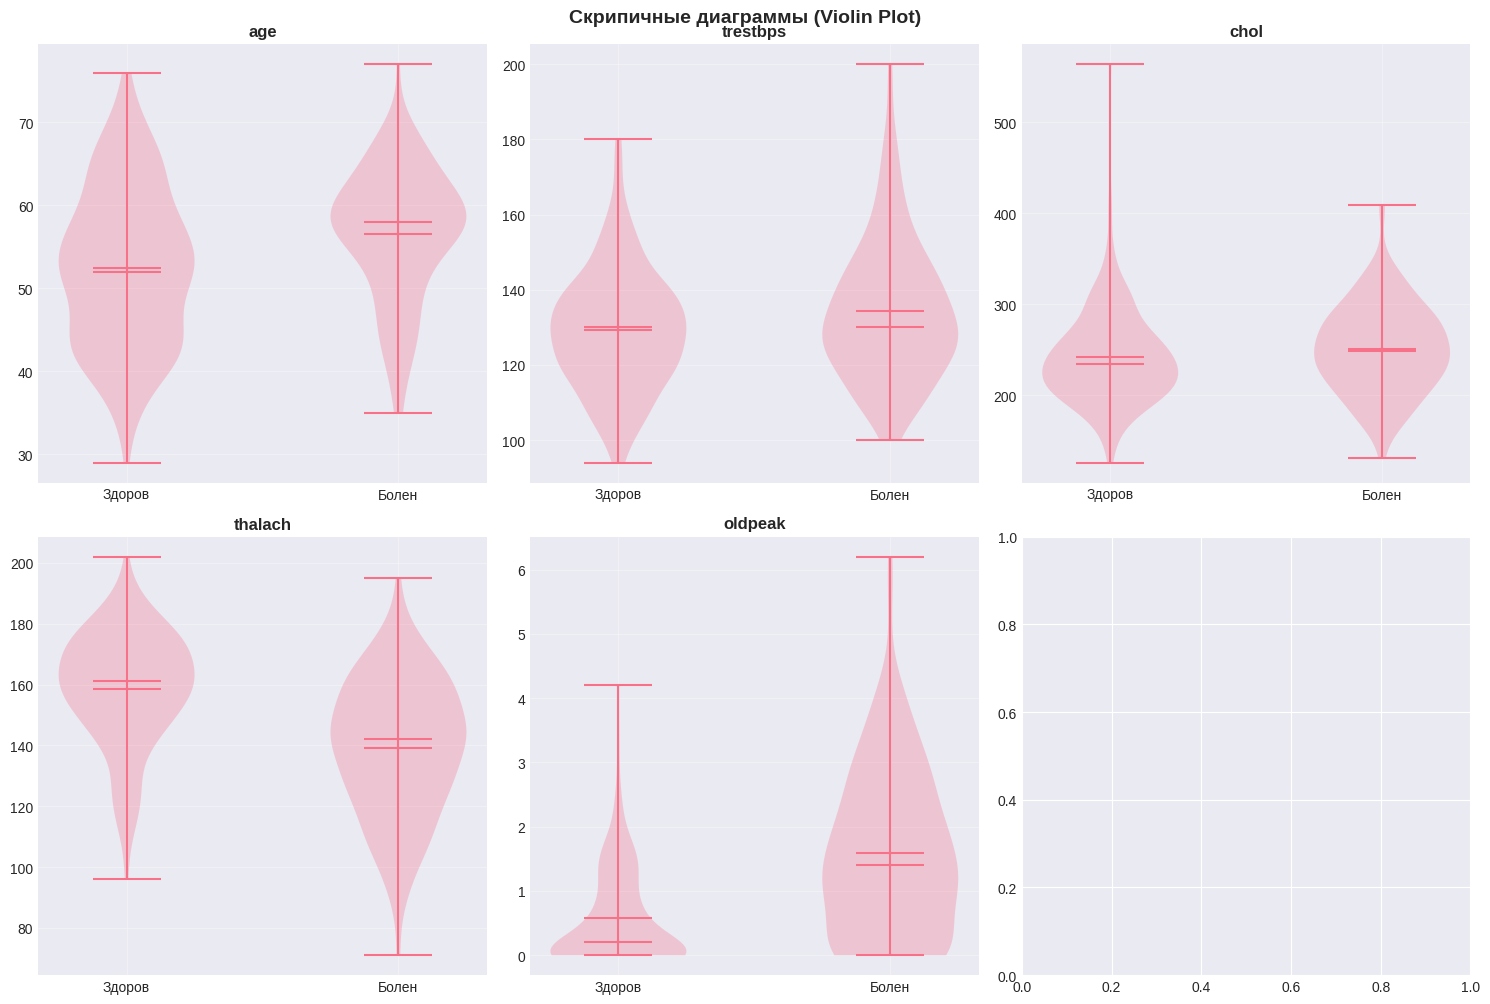

✓ Violin plot визуализирован


In [ ]:
# Скрипичные диаграммы с matplotlib
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, feature in enumerate(numeric_features[:6]):
    ax = axes[i]
    data_healthy = df_viz[df_viz['target'] == 0][feature]
    data_sick = df_viz[df_viz['target'] == 1][feature]

    parts = ax.violinplot([data_healthy.to_numpy(), data_sick.to_numpy()], positions=(1, 2), showmeans=True, showmedians=True)
    ax.set_xticks([1, 2])
    ax.set_xticklabels(['Здоров', 'Болен'])
    ax.set_title(f'{feature}', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle('Скрипичные диаграммы (Violin Plot)', y=1.00, fontsize=14, fontweight='bold')
plt.show()

print("✓ Violin plot визуализирован")

In [ ]:
### 2.4 Матрица корреляции и тепловая карта

# Вычисляем корреляционную матрицу
corr_matrix = df[numeric_features].corr()

# Тепловая карта с Plotly
fig_corr = px.imshow(corr_matrix,
                     labels=dict(color='Корреляция'),
                     x=numeric_features,
                     y=numeric_features,
                     color_continuous_scale='RdBu',
                     zmin=-1, zmax=1)
fig_corr.update_layout(title='Матрица корреляции численных признаков', height=700)
fig_corr.show()

print("✓ Матрица корреляции визуализирована")

# Анализируем корреляцию с целевым признаком
print("\n📊 КОРРЕЛЯЦИЯ ПРИЗНАКОВ С ЦЕЛЕВОЙ ПЕРЕМЕННОЙ:")
print("(Положительная корреляция = связь с болезнью, Отрицательная = связь со здоровьем)")

# Добавляем целевой признак к df для анализа
df_temp = df[numeric_features].copy()
df_temp['target'] = (df['class'] != 'H').astype(int)
correlations_with_target = df_temp.corr()['target'].drop('target').sort_values(ascending=False)
for feat, corr_val in correlations_with_target.items():
    if corr_val > 0:
        print(f"  {feat:12} : {corr_val:7.4f}  ↑ (увеличение = болезнь)")
    else:
        print(f"  {feat:12} : {corr_val:7.4f}  ↓ (снижение = болезнь)")

✓ Матрица корреляции визуализирована

📊 КОРРЕЛЯЦИЯ ПРИЗНАКОВ С ЦЕЛЕВОЙ ПЕРЕМЕННОЙ:
(Положительная корреляция = связь с болезнью, Отрицательная = связь со здоровьем)
  oldpeak      :  0.4307  ↑ (увеличение = болезнь)
  age          :  0.2254  ↑ (увеличение = болезнь)
  trestbps     :  0.1449  ↑ (увеличение = болезнь)
  chol         :  0.0852  ↑ (увеличение = болезнь)
  thalach      : -0.4217  ↓ (снижение = болезнь)


In [ ]:
### 2.5 Рассеяние точек и распределения

# Выбираем два наиболее коррелированных с целевым признаком
top_features = correlations_with_target.abs().nlargest(2).index.tolist()
feature_1, feature_2 = top_features[0], top_features[1]

# Plotly 2D scatter plot
fig_2d = px.scatter(df_viz, x=feature_1, y=feature_2, color='target_label',
                    title=f'Зависимость: {feature_1} vs {feature_2}',
                    color_discrete_map={'Здоров': 'green', 'Болен': 'red'},
                    hover_data=numeric_features)
fig_2d.update_layout(height=600)
fig_2d.show()

# Plotly 3D scatter plot
fig_3d = px.scatter_3d(df_viz, x=feature_1, y=feature_2, z='thalach',
                       color='target_label',
                       title=f'3D: {feature_1} vs {feature_2} vs thalach',
                       color_discrete_map={'Здоров': 'green', 'Болен': 'red'})
fig_3d.update_layout(height=700)
fig_3d.show()

print("✓ Интерактивные графики рассеяния визуализированы")

✓ Интерактивные графики рассеяния визуализированы


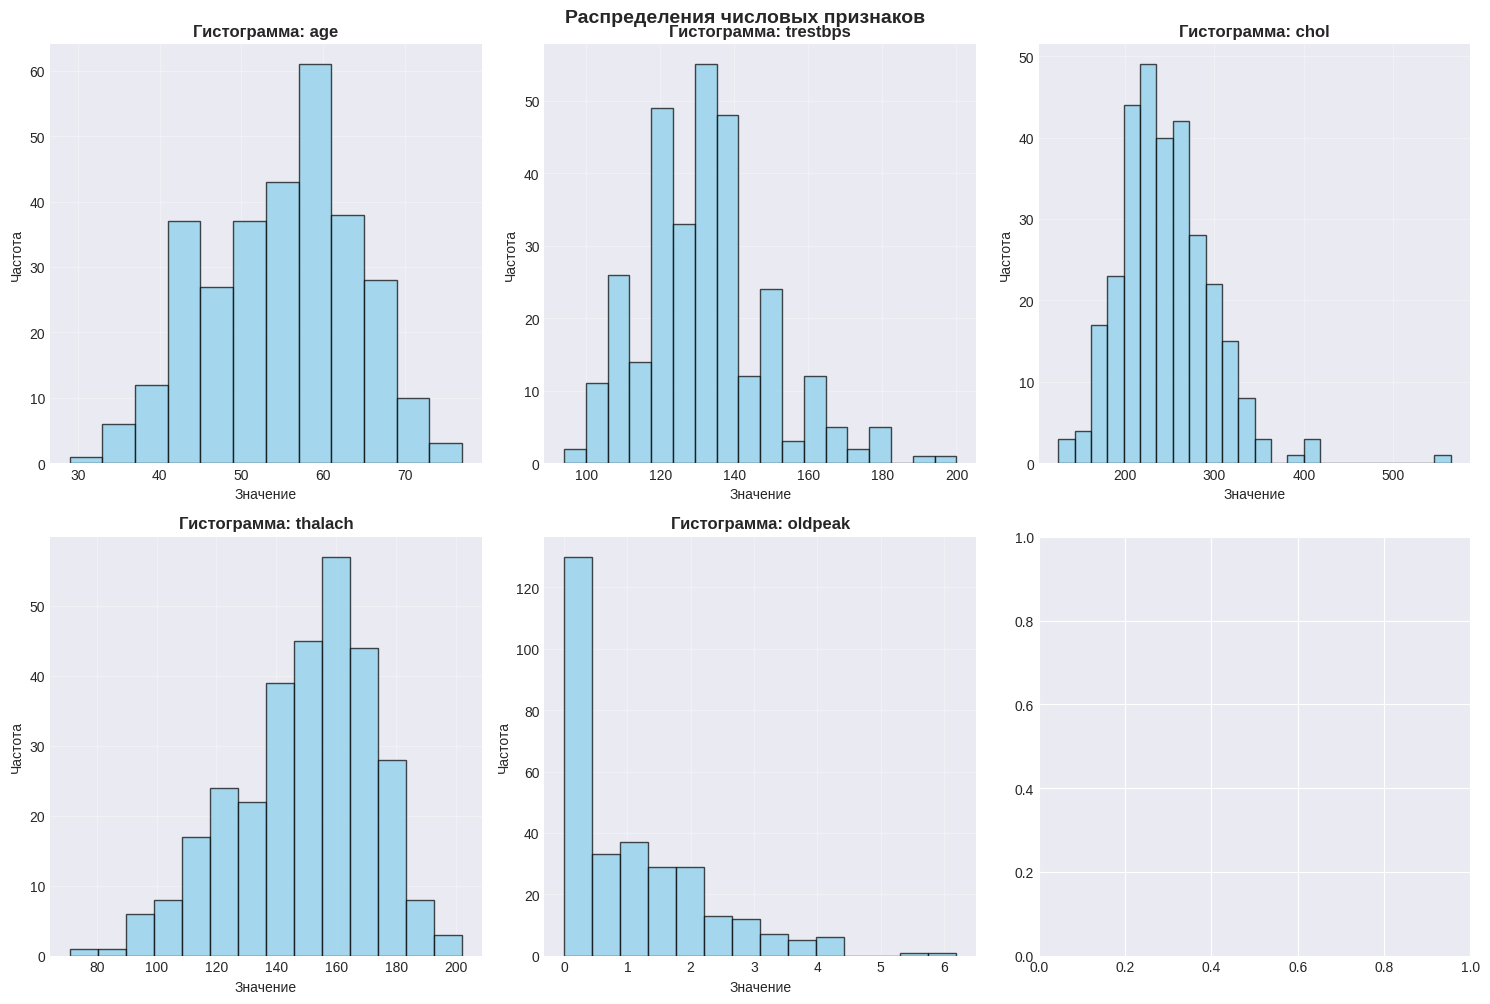

✓ Гистограммы визуализированы


In [ ]:
### 2.6 Гистограммы распределений признаков

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, feature in enumerate(numeric_features[:6]):
    ax = axes[i]
    ax.hist(df[feature], bins='auto', alpha=0.7, color='skyblue', edgecolor='black')
    ax.set_title(f'Гистограмма: {feature}', fontweight='bold')
    ax.set_xlabel('Значение')
    ax.set_ylabel('Частота')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle('Распределения числовых признаков', y=1.00, fontsize=14, fontweight='bold')
plt.show()

print("✓ Гистограммы визуализированы")

In [ ]:
### 2.7 Анализ категориальных признаков

categorical_features = df.select_dtypes(exclude=[np.number]).columns.tolist()
categorical_features.remove('class')  # Исключаем целевой признак

print("\n📊 КАТЕГОРИАЛЬНЫЕ ПРИЗНАКИ:")
for feat in categorical_features:
    print(f"\n  {feat}:")
    unique_vals = df[feat].unique()
    print(f"    Уникальные значения ({len(unique_vals)}): {', '.join(map(str, unique_vals))}")
    print(f"    Распределение: {df[feat].value_counts().to_dict()}")


📊 КАТЕГОРИАЛЬНЫЕ ПРИЗНАКИ:

  sex:
    Уникальные значения (2): male, fem
    Распределение: {'male': 207, 'fem': 96}

  cp:
    Уникальные значения (4): angina, asympt, notang, abnang
    Распределение: {'asympt': 143, 'notang': 87, 'abnang': 50, 'angina': 23}

  fbs:
    Уникальные значения (2): true, fal
    Распределение: {'fal': 258, 'true': 45}

  restecg:
    Уникальные значения (3): hyp, norm, abn
    Распределение: {'norm': 152, 'hyp': 147, 'abn': 4}

  exang:
    Уникальные значения (2): fal, true
    Распределение: {'fal': 204, 'true': 99}

  slope:
    Уникальные значения (3): down, flat, up
    Распределение: {'up': 142, 'flat': 140, 'down': 21}

  ca:
    Уникальные значения (5): 0.0, 3.0, 2.0, 1.0, ?
    Распределение: {'0.0': 175, '1.0': 65, '2.0': 38, '3.0': 20, '?': 5}

  thal:
    Уникальные значения (4): fix, norm, rev, ?
    Распределение: {'norm': 166, 'rev': 117, 'fix': 18, '?': 2}

  diagnosis:
    Уникальные значения (2): buff, sick
    Распределение: {'buff':

In [ ]:
### 2.8 Запросы к таблице с фильтрами и группировками

print("\n" + "=" * 80)
print("📋 ПРИМЕРЫ ЗАПРОСОВ К ДАТАСЕТУ")
print("=" * 80)

# Запрос 1: Простой фильтр
print("\n1️⃣ ПРОСТОЙ ФИЛЬТР: Мужчины старше 60 лет")
query1 = df[(df['sex'] == 'male') & (df['age'] > 60)][['age', 'sex', 'trestbps', 'chol', 'class']]
print(f"   Найдено записей: {len(query1)}")
print(query1.head(10))

# Запрос 2: Составной фильтр
print("\n2️⃣ СОСТАВНОЙ ФИЛЬТР: Женщины с ангиной или типичной грудной болью (cp='angina')")
query2 = df[(df['sex'] == 'fem') &
            (df['cp'].isin(['angina', 'notang'])) &
            (df['chol'] > 250)][['age', 'sex', 'cp', 'chol', 'class']]
print(f"   Найдено записей: {len(query2)}")
print(query2.head(10))

# Запрос 3: Выбор столбцов с условием
print("\n3️⃣ ВЫБОР СТОЛБЦОВ: Возраст и холестерин здоровых пациентов")
query3 = df[df['class'] == 'H'][['age', 'chol', 'thalach']].head(10)
print(query3)

# Группировка 1: По полу и классу
print("\n4️⃣ ГРУППИРОВКА: Среднее значение холестерина по полу и статусу")
group1 = df.groupby(['sex', 'class'])['chol'].agg(['mean', 'count', 'std']).round(2)
print(group1)

# Группировка 2: По типу боли в груди
print("\n5️⃣ ГРУППИРОВКА: Распределение типов боли по полу")
group2 = pd.crosstab(df['sex'], df['cp'], margins=True)
print(group2)

# Группировка 3: По нескольким критериям с несколькими агрегациями
print("\n6️⃣ СЛОЖНАЯ ГРУППИРОВКА: Статистика пульса по полу и типу боли")
group3 = df.groupby(['sex', 'cp']).agg({
    'thalach': ['mean', 'min', 'max'],
    'age': 'mean',
    'class': 'count'
}).round(2)
group3.columns = ['Пульс_среднее', 'Пульс_мин', 'Пульс_макс', 'Возраст_среднее', 'Количество']
print(group3)


📋 ПРИМЕРЫ ЗАПРОСОВ К ДАТАСЕТУ

1️⃣ ПРОСТОЙ ФИЛЬТР: Мужчины старше 60 лет
   Найдено записей: 45
     age   sex  trestbps   chol class
0   63.0  male     145.0  233.0     H
1   67.0  male     160.0  286.0    S2
2   67.0  male     120.0  229.0    S1
8   63.0  male     130.0  254.0    S2
15  64.0  male     110.0  211.0     H
27  64.0  male     140.0  335.0    S1
34  61.0  male     150.0  243.0     H
46  65.0  male     120.0  177.0     H
66  67.0  male     125.0  254.0    S3
67  62.0  male     120.0  267.0    S1

2️⃣ СОСТАВНОЙ ФИЛЬТР: Женщины с ангиной или типичной грудной болью (cp='angina')
   Найдено записей: 20
      age  sex      cp   chol class
16   58.0  fem  angina  283.0     H
21   58.0  fem  notang  340.0     H
43   65.0  fem  notang  417.0     H
58   54.0  fem  notang  304.0     H
65   65.0  fem  notang  269.0     H
70   65.0  fem  notang  360.0     H
72   51.0  fem  notang  308.0     H
84   51.0  fem  notang  256.0     H
89   63.0  fem  notang  252.0     H
102  62.0  fem  nota

## Часть 3: Подготовка данных (Data Preprocessing)

In [ ]:
print("\n" + "=" * 80)
print("🔄 ПРЕДОБРАБОТКА ДАННЫХ")
print("=" * 80)

# Копируем датасет для обработки
df_processed = df.copy()

# ✅ Шаг 1: Целевой признак
print("\n✅ Шаг 1: Преобразуем целевой признак в числовой")
df_processed['target'] = (df_processed['class'] != 'H').astype(int)
print(f"   0 (Здоров): {(df_processed['target'] == 0).sum()}")
print(f"   1 (Болен):  {(df_processed['target'] == 1).sum()}")

# ✅ Шаг 2: Кодируем категориальные признаки и очищаем данные
print("\n✅ Шаг 2: Кодируем категориальные признаки и очищаем данные")

# Сначала обработаем 'ca' - заменяем '?' на NaN, затем на медиану
print(f"   Обработка 'ca' столбца:")
df_processed['ca'] = pd.to_numeric(df_processed['ca'], errors='coerce')
ca_missing = df_processed['ca'].isna().sum()
if ca_missing > 0:
    print(f"     Найдено пропусков: {ca_missing}, заполняем медианой")
    df_processed['ca'] = df_processed['ca'].fillna(df_processed['ca'].median())

# Числовое кодирование категориальных признаков (Label Encoding)
categorical_cols = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal']
le_dict = {}

for col in categorical_cols:
    le = LabelEncoder()
    df_processed[col + '_encoded'] = le.fit_transform(df_processed[col])
    le_dict[col] = le
    print(f"   {col}: {dict(list(zip(le.classes_, le.transform(le.classes_))))}")

# Преобразуем 'ca' в числовой тип, заменяя '?' на NaN, а затем на медиану
print(f"\n   Обработка 'ca' столбца:")
print(f"   Исходные значения: {df_processed['ca'].unique()}")
df_processed['ca'] = pd.to_numeric(df_processed['ca'], errors='coerce')
ca_missing = df_processed['ca'].isna().sum()
if ca_missing > 0:
    print(f"   Найдено пропусков: {ca_missing}, заполняем медианой")
    df_processed['ca'] = df_processed['ca'].fillna(df_processed['ca'].median())
print(f"   После обработки: {df_processed['ca'].unique()}")

# ✅ Шаг 3: Удаляем выбросы
print("\n✅ Шаг 3: Удаляем выбросы (используем IQR метод)")

# Функция для удаления выбросов
def remove_outliers(data, columns, iqr_multiplier=1.5):
    for col in columns:
        Q1 = data[col].quantile(0.25)
        Q3 = data[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - iqr_multiplier * IQR
        upper_bound = Q3 + iqr_multiplier * IQR
        data = data[(data[col] >= lower_bound) & (data[col] <= upper_bound)]
    return data

# Определяем выбросы
numeric_cols_to_check = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak', 'ca']
initial_size = len(df_processed)
df_processed = remove_outliers(df_processed, numeric_cols_to_check, iqr_multiplier=1.5)
final_size = len(df_processed)
removed_count = initial_size - final_size

print(f"   Удалено выбросов: {removed_count} ({removed_count/initial_size*100:.1f}%)")
print(f"   Осталось строк: {final_size}")

# ✅ Шаг 4: Удаляем дубликаты
print("\n✅ Шаг 4: Удаляем дубликаты")
duplicates_before = df_processed.duplicated().sum()
df_processed = df_processed.drop_duplicates()
print(f"   Удалено дубликатов: {duplicates_before}")

# ✅ Шаг 5: Масштабируем признаки
print("\n✅ Шаг 5: Подготавливаем признаки для масштабирования")

# Выбираем признаки для модели
feature_cols = numeric_cols_to_check + [col + '_encoded' for col in categorical_cols]
X = df_processed[feature_cols].copy()
y = df_processed['target'].copy()

print(f"   Признаки для модели: {len(feature_cols)}")
print(f"   Финальный размер: X={X.shape}, y={y.shape}")


🔄 ПРЕДОБРАБОТКА ДАННЫХ

✅ Шаг 1: Преобразуем целевой признак в числовой
   0 (Здоров): 165
   1 (Болен):  138

✅ Шаг 2: Кодируем категориальные признаки и очищаем данные
   Обработка 'ca' столбца:
     Найдено пропусков: 5, заполняем медианой
   sex: {'fem': np.int64(0), 'male': np.int64(1)}
   cp: {'abnang': np.int64(0), 'angina': np.int64(1), 'asympt': np.int64(2), 'notang': np.int64(3)}
   fbs: {'fal': np.int64(0), 'true': np.int64(1)}
   restecg: {'abn': np.int64(0), 'hyp': np.int64(1), 'norm': np.int64(2)}
   exang: {'fal': np.int64(0), 'true': np.int64(1)}
   slope: {'down': np.int64(0), 'flat': np.int64(1), 'up': np.int64(2)}
   thal: {'?': np.int64(0), 'fix': np.int64(1), 'norm': np.int64(2), 'rev': np.int64(3)}

   Обработка 'ca' столбца:
   Исходные значения: [0. 3. 2. 1.]
   После обработки: [0. 3. 2. 1.]

✅ Шаг 3: Удаляем выбросы (используем IQR метод)
   Удалено выбросов: 35 (11.6%)
   Осталось строк: 268

✅ Шаг 4: Удаляем дубликаты
   Удалено дубликатов: 1

✅ Шаг 5: Подг

In [ ]:
# ✅ Шаг 6: Разделяем на train/test
print("\n✅ Шаг 6: Разделяем данные на тренировочную и тестовую выборки")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"   Тренировка: {X_train.shape}")
print(f"   Тест: {X_test.shape}")
print(f"   Баланс класов в train: {y_train.value_counts().to_dict()}")
print(f"   Баланс классов в test: {y_test.value_counts().to_dict()}")

# ✅ Шаг 7: Масштабируем признаки (StandardScaler)
print("\n✅ Шаг 7: Масштабируем признаки (StandardScaler)")
print("   Причина: различные масштабы признаков (age: 30-90, ca: 0-3)")
print("   Логистическая регрессия использует градиент, поэтому масштабирование важно")

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Преобразуем обратно в DataFrame для удобства
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

print(f"\n   До масштабирования - age: min={X_train['age'].min():.2f}, max={X_train['age'].max():.2f}")
print(f"   После масштабирования - age: min={X_train_scaled['age'].min():.2f}, max={X_train_scaled['age'].max():.2f}")
print(f"\n   До масштабирования - ca: min={X_train['ca'].min():.2f}, max={X_train['ca'].max():.2f}")
print(f"   После масштабирования - ca: min={X_train_scaled['ca'].min():.2f}, max={X_train_scaled['ca'].max():.2f}")

print("\n✓ Подготовка данных завершена!")


✅ Шаг 6: Разделяем данные на тренировочную и тестовую выборки
   Тренировка: (213, 13)
   Тест: (54, 13)
   Баланс класов в train: {0: 124, 1: 89}
   Баланс классов в test: {0: 31, 1: 23}

✅ Шаг 7: Масштабируем признаки (StandardScaler)
   Причина: различные масштабы признаков (age: 30-90, ca: 0-3)
   Логистическая регрессия использует градиент, поэтому масштабирование важно

   До масштабирования - age: min=34.00, max=74.00
   После масштабирования - age: min=-2.24, max=2.32

   До масштабирования - ca: min=0.00, max=2.00
   После масштабирования - ca: min=-0.71, max=2.11

✓ Подготовка данных завершена!


## Часть 4: Построение модели логистической регрессии

### Формула логистической регрессии

$$P(y=1|x) = \frac{1}{1 + e^{-(\beta_0 + \beta_1 x_1 + \beta_2 x_2 + ... + \beta_n x_n)}}$$

Или эквивалентно:
$$z = \beta_0 + \beta_1 x_1 + ... + \beta_n x_n$$
$$P(y=1|x) = \sigma(z) = \frac{1}{1 + e^{-z}}$$

**Пояснения:**
- **$P(y=1|x)$** - вероятность того, что объект принадлежит к положительному классу (болен)
- **$\beta_0$** - смещение (intercept/bias)
- **$\beta_i$** - коэффициент при признаке $x_i$ (влияние признака на логарифм шансов)
- **$\sigma(z)$** - сигмоидная функция (преобразует вещественное число в вероятность [0, 1])
- **Функция потерь:** Log Loss / Cross-Entropy

In [ ]:
print("\n" + "=" * 80)
print("🧠 ПОСТРОЕНИЕ И ОЦЕНКА ЛОГИСТИЧЕСКОЙ РЕГРЕССИИ")
print("=" * 80)

# Обучаем модель логистической регрессии на масштабированных данных
print("\n🔧 Обучаем модель LogisticRegression...")
log_model = LogisticRegression(max_iter=1000, random_state=42, solver='lbfgs')
log_model.fit(X_train_scaled, y_train)

print(f"✓ Модель успешно обучена")
print(f"\n📊 Параметры модели:")
print(f"   Количество итераций: {log_model.n_iter_[0]}")
print(f"   Intercept (смещение): {log_model.intercept_[0]:.6f}")
print(f"\n   Коэффициенты (β):")
coef_df = pd.DataFrame({
    'Признак': X_train.columns,
    'Коэффициент': log_model.coef_[0]
}).sort_values('Коэффициент', key=abs, ascending=False)

for idx, row in coef_df.iterrows():
    direction = "↑ увеличивает риск" if row['Коэффициент'] > 0 else "↓ снижает риск"
    print(f"   {row['Признак']:20} : {row['Коэффициент']:8.4f}  {direction}")


🧠 ПОСТРОЕНИЕ И ОЦЕНКА ЛОГИСТИЧЕСКОЙ РЕГРЕССИИ

🔧 Обучаем модель LogisticRegression...
✓ Модель успешно обучена

📊 Параметры модели:
   Количество итераций: 8
   Intercept (смещение): -0.412622

   Коэффициенты (β):
   ca                   :   1.0727  ↑ увеличивает риск
   sex_encoded          :   0.7334  ↑ увеличивает риск
   exang_encoded        :   0.6386  ↑ увеличивает риск
   thal_encoded         :   0.5711  ↑ увеличивает риск
   oldpeak              :   0.4731  ↑ увеличивает риск
   thalach              :  -0.4234  ↓ снижает риск
   trestbps             :   0.3444  ↑ увеличивает риск
   age                  :  -0.2945  ↓ снижает риск
   chol                 :   0.2864  ↑ увеличивает риск
   slope_encoded        :  -0.2643  ↓ снижает риск
   fbs_encoded          :  -0.1816  ↓ снижает риск
   restecg_encoded      :  -0.1782  ↓ снижает риск
   cp_encoded           :   0.0771  ↑ увеличивает риск


In [ ]:
### 4.1 Оценка модели на тестовой выборке

print("\n" + "-" * 80)
print("📈 ОЦЕНКА КАЧЕСТВА НА ТЕСТОВОЙ ВЫБОРКЕ")
print("-" * 80)

# Предсказания
y_pred = log_model.predict(X_test_scaled)
y_pred_proba = log_model.predict_proba(X_test_scaled)[:, 1]

# Вычисляем метрики
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f"\n🎯 ОСНОВНЫЕ МЕТРИКИ:")
print(f"   Accuracy (Точность):       {accuracy:.4f}")
print(f"      └─ Доля правильных предсказаний: {accuracy*100:.2f}%")
print(f"\n   Precision (Положительная предсказательная ценность): {precision:.4f}")
print(f"      └─ Из предсказанных как 'болен' действительно болны: {precision*100:.2f}%")
print(f"\n   Recall (Полнота/Чувствительность): {recall:.4f}")
print(f"      └─ Из всех больных найдено: {recall*100:.2f}%")
print(f"\n   F1-Score (гармоническое среднее): {f1:.4f}")
print(f"      └─ Баланс между Precision и Recall")
print(f"\n   ROC-AUC:                    {roc_auc:.4f}")
print(f"      └─ Способность различать классы (0.5=случайно, 1.0=идеально)")

# Матрица ошибок
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

print(f"\n📊 МАТРИЦА ОШИБОК (Confusion Matrix):")
print(f"   ┌─────────────────┬─────────────────┐")
print(f"   │  Истинно (0)    │  Истинно (1)    │")
print(f"   ├─────────────────┼─────────────────┤")
print(f"   │ TN={tn:3d}       │ FP={fp:3d}       │ Предск. (0)")
print(f"   │ FN={fn:3d}       │ TP={tp:3d}       │ Предск. (1)")
print(f"   └─────────────────┴─────────────────┘")

print(f"\n   Интерпретация:")
print(f"   • True Negative (TN={tn}):  правильно предсказаны здоровые")
print(f"   • False Positive (FP={fp}): ошибочно предсказаны как больные")
print(f"   • False Negative (FN={fn}): ошибочно предсказаны как здоровые (опасно!)")
print(f"   • True Positive (TP={tp}):  правильно предсказаны больные")

# Подробный отчёт
print(f"\n📋 CLASSIFICATION REPORT:")
print(classification_report(y_test, y_pred, target_names=['Здоров', 'Болен']))


--------------------------------------------------------------------------------
📈 ОЦЕНКА КАЧЕСТВА НА ТЕСТОВОЙ ВЫБОРКЕ
--------------------------------------------------------------------------------

🎯 ОСНОВНЫЕ МЕТРИКИ:
   Accuracy (Точность):       0.7778
      └─ Доля правильных предсказаний: 77.78%

   Precision (Положительная предсказательная ценность): 0.7619
      └─ Из предсказанных как 'болен' действительно болны: 76.19%

   Recall (Полнота/Чувствительность): 0.6957
      └─ Из всех больных найдено: 69.57%

   F1-Score (гармоническое среднее): 0.7273
      └─ Баланс между Precision и Recall

   ROC-AUC:                    0.9187
      └─ Способность различать классы (0.5=случайно, 1.0=идеально)

📊 МАТРИЦА ОШИБОК (Confusion Matrix):
   ┌─────────────────┬─────────────────┐
   │  Истинно (0)    │  Истинно (1)    │
   ├─────────────────┼─────────────────┤
   │ TN= 26       │ FP=  5       │ Предск. (0)
   │ FN=  7       │ TP= 16       │ Предск. (1)
   └─────────────────┴─────────

### 3. Часть 3: Data Preprocessing (Подготовка данных)

In [ ]:
print("\n" + "=" * 80)
print("🔧 ПРЕДОБРАБОТКА ДАННЫХ")
print("=" * 80)

# Шаг 1: Преобразуем целевой признак в числовой
df['target'] = (df['class'] != 'H').astype(int)
print("\n✅ Шаг 1: Целевой признак преобразован")
print(f"   H (здоров) → 0, S1-S4 (болен) → 1")
print(f"   Распределение: {df['target'].value_counts().to_dict()}")

# Шаг 2: Кодируем категориальные признаки
print("\n✅ Шаг 2: Кодирование категориальных признаков")
df_processed = df.copy()
categorical_cols = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal']

for col in categorical_cols:
  #OneHotEncoder
    le = V()
    df_processed[col + '_encoded'] = le.fit_transform(df_processed[col].astype(str))

print(f"   Закодировано {len(categorical_cols)} категориальных признаков")

# Шаг 3: Удаляем выбросы методом IQR
print("\n✅ Шаг 3: Удаление выбросов (IQR метод)")
numeric_cols_to_check = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
rows_before = len(df_processed)

for col in numeric_cols_to_check:
    Q1 = df_processed[col].quantile(0.25)
    Q3 = df_processed[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df_processed = df_processed[(df_processed[col] >= lower_bound) & (df_processed[col] <= upper_bound)]

rows_removed = rows_before - len(df_processed)
print(f"   Удалено {rows_removed} выбросов ({rows_removed/rows_before*100:.1f}%)")

# Шаг 4: Удаляем дубликаты
print("\n✅ Шаг 4: Удаление дубликатов")
duplicates_before = df_processed.duplicated().sum()
df_processed = df_processed.drop_duplicates()
print(f"   Удалено {duplicates_before} дубликатов")

# Шаг 5: Подготавливаем признаки для модели
print("\n✅ Шаг 5: Подготовка признаков")
numeric_features = numeric_cols_to_check
encoded_features = [col + '_encoded' for col in categorical_cols]
feature_cols = numeric_features + encoded_features

X_processed = df_processed[feature_cols]
y_processed = df_processed['target']

print(f"   Всего признаков: {len(feature_cols)}")
print(f"   Числовых: {len(numeric_features)}, Закодированных категориальных: {len(encoded_features)}")
print(f"   Размер: ({len(X_processed)}, {len(feature_cols)})")

# Шаг 6: Разделяем на train/test с стратификацией
print("\n✅ Шаг 6: Разделение на train/test")
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y_processed,
    test_size=0.2,
    random_state=42,
    stratify=y_processed
)
print(f"   Train: {len(X_train)} примеров")
print(f"   Test: {len(X_test)} примеров")

# Шаг 7: Масштабируем признаки
print("\n✅ Шаг 7: Масштабирование признаков (StandardScaler)")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Конвертируем обратно в DataFrame для удобства
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

print(f"   Масштабирование завершено")
print(f"\n✓ Предобработка завершена успешно!")


🔧 ПРЕДОБРАБОТКА ДАННЫХ

✅ Шаг 1: Целевой признак преобразован
   H (здоров) → 0, S1-S4 (болен) → 1
   Распределение: {0: 165, 1: 138}

✅ Шаг 2: Кодирование категориальных признаков
   Закодировано 7 категориальных признаков

✅ Шаг 3: Удаление выбросов (IQR метод)
   Удалено 19 выбросов (6.3%)

✅ Шаг 4: Удаление дубликатов
   Удалено 1 дубликатов

✅ Шаг 5: Подготовка признаков
   Всего признаков: 12
   Числовых: 5, Закодированных категориальных: 7
   Размер: (283, 12)

✅ Шаг 6: Разделение на train/test
   Train: 226 примеров
   Test: 57 примеров

✅ Шаг 7: Масштабирование признаков (StandardScaler)
   Масштабирование завершено

✓ Предобработка завершена успешно!


### 4. Часть 4: Улучшенная модель

In [ ]:
print("\n" + "=" * 80)
print("🤖 УЛУЧШЕННАЯ МОДЕЛЬ: Логистическая регрессия на всех признаках")
print("=" * 80)

# Обучаем модель на масштабированных данных
log_model = LogisticRegression(max_iter=1000, random_state=42, solver='lbfgs')
log_model.fit(X_train_scaled, y_train)

# Прогнозы на тестовой выборке
y_pred = log_model.predict(X_test_scaled)
y_pred_proba = log_model.predict_proba(X_test_scaled)[:, 1]

# Вычисляем метрики
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
cm = confusion_matrix(y_test, y_pred)


print("\n📊 РЕЗУЛЬТАТЫ УЛУЧШЕННОЙ МОДЕЛИ:")
print(f"  Accuracy (точность):        {accuracy:.4f}")
print(f"  Precision (полнота):        {precision:.4f}")
print(f"  Recall (чувствительность):  {recall:.4f}")
print(f"  F1-score:                   {f1:.4f}")
print(f"  ROC-AUC:                    {roc_auc:.4f}")

print(f"\n📊 Матрица ошибок:")
print(f"  [[TN={cm[0,0]} FP={cm[0,1]}]")
print(f"   [FN={cm[1,0]} TP={cm[1,1]}]]")

# Сравнение с baseline
print(f"\n📈 УЛУЧШЕНИЕ ОТНОСИТЕЛЬНО BASELINE:")
print(f"  Accuracy: {(accuracy - acc_bl)*100:+.2f}% ({acc_bl:.4f} → {accuracy:.4f})")
print(f"  F1-score: {(f1 - f1_bl)*100:+.2f}%")
print(f"  ROC-AUC: {(roc_auc - roc_auc_bl)*100:+.2f}%")


🤖 УЛУЧШЕННАЯ МОДЕЛЬ: Логистическая регрессия на всех признаках

📊 РЕЗУЛЬТАТЫ УЛУЧШЕННОЙ МОДЕЛИ:
  Accuracy (точность):        0.7895
  Precision (полнота):        0.7407
  Recall (чувствительность):  0.8000
  F1-score:                   0.7692
  ROC-AUC:                    0.8875

📊 Матрица ошибок:
  [[TN=25 FP=7]
   [FN=5 TP=20]]

📈 УЛУЧШЕНИЕ ОТНОСИТЕЛЬНО BASELINE:
  Accuracy: +5.18% (0.7377 → 0.7895)
  F1-score: +5.49%
  ROC-AUC: +7.15%


In [ ]:
print(classification_report(y_test,y_pred))


              precision    recall  f1-score   support

           0       0.83      0.78      0.81        32
           1       0.74      0.80      0.77        25

    accuracy                           0.79        57
   macro avg       0.79      0.79      0.79        57
weighted avg       0.79      0.79      0.79        57



### 5. Создание Pipeline и сохранение моделей

In [ ]:
print("\n" + "=" * 80)
print("💾 СОЗДАНИЕ PIPELINE И СОХРАНЕНИЕ МОДЕЛЕЙ")
print("=" * 80)

import os
import pickle
import json

# Создаём pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('logistic_regression', LogisticRegression(max_iter=1000, random_state=42, solver='lbfgs'))
])

# Обучаем pipeline на всех данных
pipeline.fit(X_train_scaled, y_train)

# Оцениваем pipeline
y_pred_pipeline = pipeline.predict(X_test_scaled)
accuracy_pipeline = accuracy_score(y_test, y_pred_pipeline)

print(f"\n✓ Pipeline создан и обучен")
print(f"   Accuracy на тесте: {accuracy_pipeline:.4f}")

# Сохраняем модели
os.makedirs('models', exist_ok=True)

model_path = 'models/heart_disease_logistic_model.pkl'
scaler_path = 'models/scaler.pkl'
pipeline_path = 'models/pipeline.pkl'
encoders_path = 'models/label_encoders.pkl'

# Сохраняем компоненты
with open(model_path, 'wb') as f:
    pickle.dump(log_model, f)

with open(scaler_path, 'wb') as f:
    pickle.dump(scaler, f)

with open(pipeline_path, 'wb') as f:
    pickle.dump(pipeline, f)

print(f"\n✓ Модели сохранены:")
print(f"   {model_path}")
print(f"   {scaler_path}")
print(f"   {pipeline_path}")

# Сохраняем конфигурацию
config = {
    'feature_names': X_train.columns.tolist(),
    'feature_names_numeric': numeric_features,
    'feature_names_categorical': categorical_cols,
    'model_type': 'LogisticRegression',
    'accuracy': float(accuracy),
    'precision': float(precision),
    'recall': float(recall),
    'f1': float(f1),
    'roc_auc': float(roc_auc),
    'train_size': int(len(X_train)),
    'test_size': int(len(X_test)),
}

with open('models/config.json', 'w') as f:
    json.dump(config, f, indent=2)

print(f"   models/config.json")

# Загружаем модель для проверки
with open(pipeline_path, 'rb') as f:
    loaded_pipeline = pickle.load(f)

print(f"\n✓ Проверка загрузки: pipeline успешно загружен")
print(f"   Загруженный pipeline пригоден к использованию")


💾 СОЗДАНИЕ PIPELINE И СОХРАНЕНИЕ МОДЕЛЕЙ

✓ Pipeline создан и обучен
   Accuracy на тесте: 0.7895

✓ Модели сохранены:
   models/heart_disease_logistic_model.pkl
   models/scaler.pkl
   models/pipeline.pkl
   models/config.json

✓ Проверка загрузки: pipeline успешно загружен
   Загруженный pipeline пригоден к использованию


In [ ]:
### 4.2 Кросс-валидация

print("\n" + "-" * 80)
print("🔄 КРОСС-ВАЛИДАЦИЯ")
print("-" * 80)


skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores_acc = cross_val_score(log_model, X_train_scaled, y_train, cv=skf, scoring='accuracy')
cv_scores_f1 = cross_val_score(log_model, X_train_scaled, y_train, cv=skf, scoring='f1')
cv_scores_roc_auc = cross_val_score(log_model, X_train_scaled, y_train, cv=skf, scoring='roc_auc')

print(f"\nКРОСС-ВАЛИДАЦИЯ РЕЗУЛЬТАТ:")
print(f"\n   Accuracy: {cv_scores_acc}")
print(f"   Mean: {cv_scores_acc.mean():.4f} (+/- {cv_scores_acc.std():.4f})")

print(f"\n   F1-Score: {cv_scores_f1}")
print(f"   Mean: {cv_scores_f1.mean():.4f} (+/- {cv_scores_f1.std():.4f})")

print(f"\n   ROC-AUC: {cv_scores_roc_auc}")
print(f"   Mean: {cv_scores_roc_auc.mean():.4f} (+/- {cv_scores_roc_auc.std():.4f})")

print(f"\nИнтерпретация кросс-валидации:")
print(f"   Модель показывает стабильные результаты на разных фолдах(группах).")
print(f"   Низкая стандартная ошибка означает низкое переобучение.")


--------------------------------------------------------------------------------
🔄 КРОСС-ВАЛИДАЦИЯ
--------------------------------------------------------------------------------

КРОСС-ВАЛИДАЦИЯ РЕЗУЛЬТАТ:

   Accuracy: [0.67391304 0.84444444 0.73333333 0.75555556 0.73333333]
   Mean: 0.7481 (+/- 0.0553)

   F1-Score: [0.57142857 0.82051282 0.72727273 0.71794872 0.7       ]
   Mean: 0.7074 (+/- 0.0798)

   ROC-AUC: [0.71346154 0.938      0.86       0.864      0.814     ]
   Mean: 0.8379 (+/- 0.0738)

Интерпретация кросс-валидации:
   Модель показывает стабильные результаты на разных фолдах.
   Низкая стандартная ошибка означает низкое переобучение.


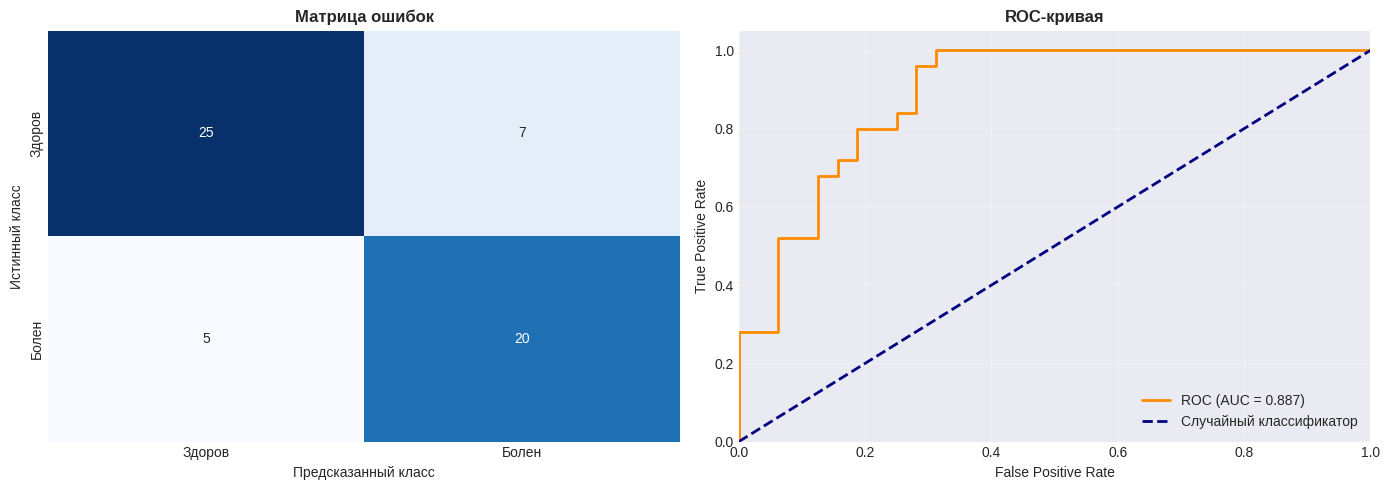

✓ ROC-кривая и матрица ошибок визуализированы


In [ ]:
### 4.3 Визуализация результатов

# Визуализация матрицы ошибок
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Матрица ошибок
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0], cbar=False,
            xticklabels=['Здоров', 'Болен'], yticklabels=['Здоров', 'Болен'])
axes[0].set_title('Матрица ошибок', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Истинный класс')
axes[0].set_xlabel('Предсказанный класс')

# ROC-кривая
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
axes[1].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC (AUC = {roc_auc:.3f})')
axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Случайный классификатор')
axes[1].set_xlim((0.0, 1.0))
axes[1].set_ylim((0.0, 1.05))
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC-кривая', fontsize=12, fontweight='bold')
axes[1].legend(loc="lower right")
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ ROC-кривая и матрица ошибок визуализированы")

## Часть 5: Сравнение с BASELINE моделью


📊 СРАВНЕНИЕ: BASELINE vs УЛУЧШЕННАЯ МОДЕЛЬ

   Метрика  Baseline  Улучшенная  Улучшение  Улучшение %
 Accuracy  0.737705    0.789474   0.051769         7.02
Precision  0.714286    0.740741   0.026455         3.70
   Recall  0.714286    0.800000   0.085714        12.00
 F1-Score  0.714286    0.769231   0.054945         7.69
  ROC-AUC  0.816017    0.887500   0.071483         8.76


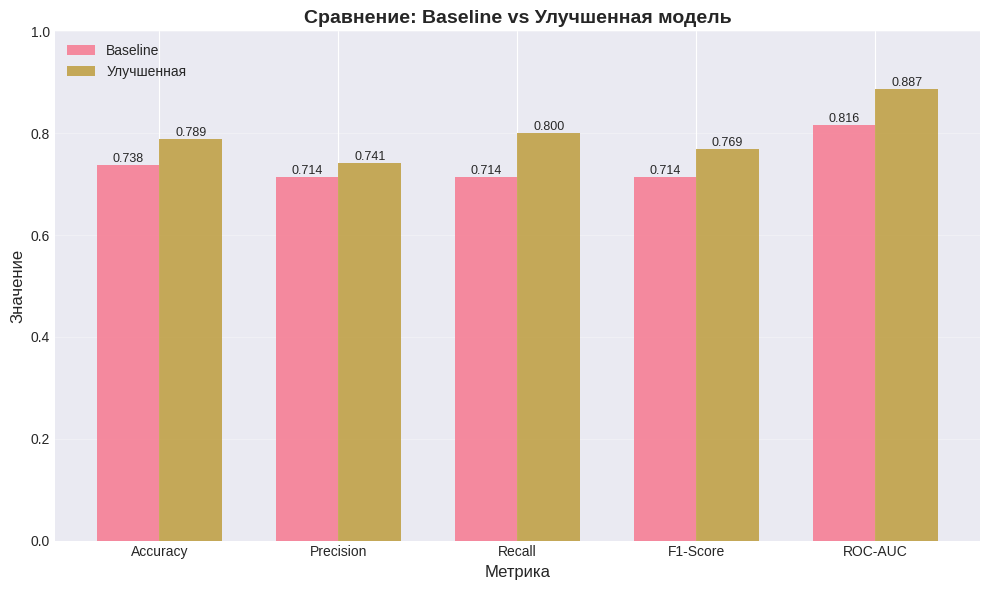


✅ ВЫВОД:
   Улучшенная модель показывает ЛУЧШИЕ результаты!
   Среднее улучшение: 0.0581


In [ ]:
print("\n" + "=" * 80)
print("📊 СРАВНЕНИЕ: BASELINE vs УЛУЧШЕННАЯ МОДЕЛЬ")
print("=" * 80)

comparison_data = {
    'Метрика': ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC'],
    'Baseline': [acc_bl, prec_bl, rec_bl, f1_bl, roc_auc_bl],
    'Улучшенная': [accuracy, precision, recall, f1, roc_auc]
}

comparison_df = pd.DataFrame(comparison_data)
comparison_df['Улучшение'] = comparison_df['Улучшенная'] - comparison_df['Baseline']
comparison_df['Улучшение %'] = (comparison_df['Улучшение'] / comparison_df['Baseline'] * 100).round(2)

print("\n", comparison_df.to_string(index=False))

# Визуализация сравнения
fig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(len(comparison_df))
width = 0.35

bars1 = ax.bar(x - width/2, comparison_df['Baseline'], width, label='Baseline', alpha=0.8)
bars2 = ax.bar(x + width/2, comparison_df['Улучшенная'], width, label='Улучшенная', alpha=0.8)

ax.set_xlabel('Метрика', fontsize=12)
ax.set_ylabel('Значение', fontsize=12)
ax.set_title('Сравнение: Baseline vs Улучшенная модель', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(comparison_df['Метрика'])
ax.legend()
ax.grid(True, alpha=0.3, axis='y')
ax.set_ylim((0, 1))

# Добавляем значения на столбцы
for bar in bars1:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.3f}', ha='center', va='bottom', fontsize=9)
for bar in bars2:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

print(f"\n✅ ВЫВОД:")
if comparison_df['Улучшение'].sum() > 0:
    print(f"   Улучшенная модель показывает ЛУЧШИЕ результаты!")
    print(f"   Среднее улучшение: {comparison_df['Улучшение'].mean():.4f}")
else:
    print(f"   Результаты сопоставимы с baseline")

## Часть 6: Анализ важности признаков

### 6.1 Важность на основе коэффициентов регрессии

Так как признаки масштабированы (StandardScaler), коэффициенты регрессии отражают относительное влияние на логарифм шансов:

$$\log\left(\frac{P(y=1)}{P(y=0)}\right) = \beta_0 + \sum_{i=1}^{n} \beta_i x_i$$

**Интерпретация:** Если $\beta_i > 0$, то увеличение признака $x_i$ на 1 стандартное отклонение увеличивает логарифм шансов болезни на $\beta_i$ единиц.


📊 АНАЛИЗ ВАЖНОСТИ ПРИЗНАКОВ

1️⃣ КОЭФФИЦИЕНТЫ ЛОГИСТИЧЕСКОЙ РЕГРЕССИИ:
   (Признаки масштабированы, поэтому коэффициенты сопоставимы)
        Признак  Коэффициент
    sex_encoded     0.763059
        thalach    -0.662739
  exang_encoded     0.653995
        oldpeak     0.583526
   thal_encoded     0.519398
           chol     0.279413
restecg_encoded    -0.183818
     cp_encoded    -0.148084
       trestbps     0.103408
    fbs_encoded    -0.085077
  slope_encoded    -0.057114
            age    -0.037295


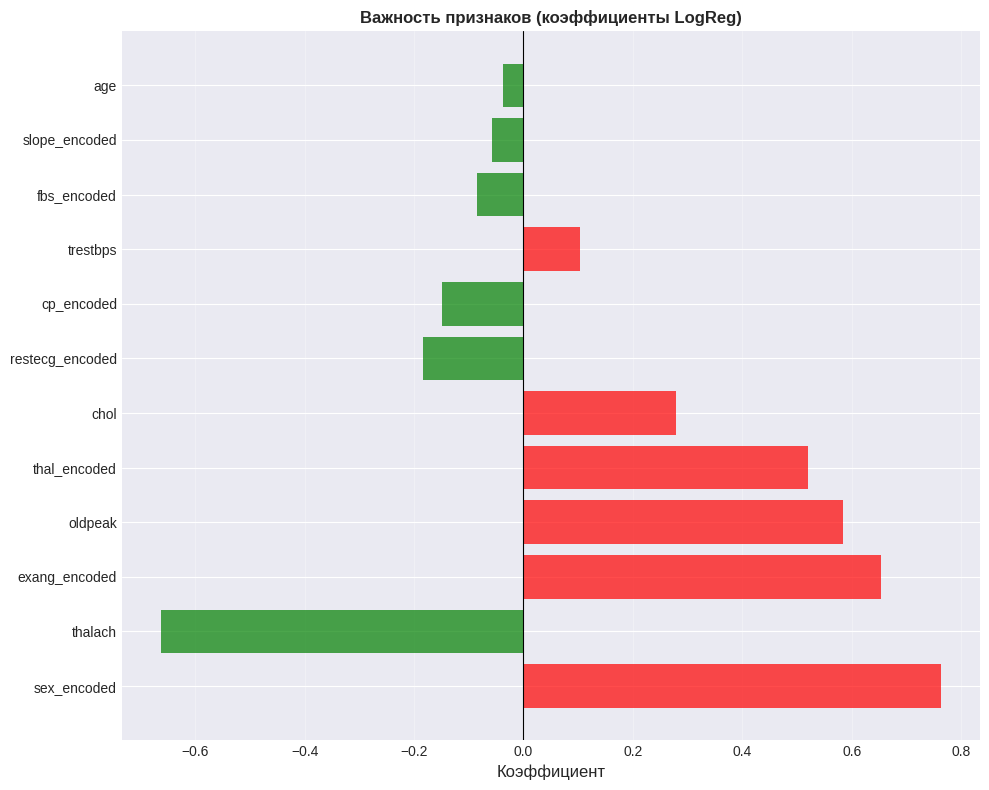


   🔴 Красные столбцы: увеличивают риск болезни
   🟢 Зелёные столбцы: снижают риск болезни


In [ ]:
print("\n" + "=" * 80)
print("📊 АНАЛИЗ ВАЖНОСТИ ПРИЗНАКОВ")
print("=" * 80)

print("\n1️⃣ КОЭФФИЦИЕНТЫ ЛОГИСТИЧЕСКОЙ РЕГРЕССИИ:")
print("   (Признаки масштабированы, поэтому коэффициенты сопоставимы)")

coef_importance = pd.DataFrame({
    'Признак': X_train.columns,
    'Коэффициент': log_model.coef_[0],
    'Абс. значение': np.abs(log_model.coef_[0])
}).sort_values('Абс. значение', ascending=False)

print(coef_importance[['Признак', 'Коэффициент']].to_string(index=False))

# Визуализация коэффициентов
fig, ax = plt.subplots(figsize=(10, 8))
colors = ['red' if x > 0 else 'green' for x in coef_importance['Коэффициент']]
ax.barh(range(len(coef_importance)), coef_importance['Коэффициент'], color=colors, alpha=0.7)
ax.set_yticks(range(len(coef_importance)))
ax.set_yticklabels(coef_importance['Признак'])
ax.set_xlabel('Коэффициент', fontsize=12)
ax.set_title('Важность признаков (коэффициенты LogReg)', fontsize=12, fontweight='bold')
ax.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
ax.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

print("\n   🔴 Красные столбцы: увеличивают риск болезни")
print("   🟢 Зелёные столбцы: снижают риск болезни")

In [ ]:
print("\n2️⃣ КОРРЕЛЯЦИЯ С ЦЕЛЕВЫМ ПРИЗНАКОМ:")
print("   (Меры линейной связи в исходных данных)")

# Вычисляем корреляции
corr_importance = pd.DataFrame({
    'Признак': X_train.columns,
    'Корреляция': [X_train[col].corr(y_train) for col in X_train.columns],
}).sort_values('Корреляция', key=abs, ascending=False)

print(corr_importance.to_string(index=False))

# Сравнение коэффициентов и корреляций
comparison_importance = pd.merge(
    coef_importance[['Признак', 'Коэффициент']],
    corr_importance,
    on='Признак'
)

# Добавляем столбец с абсолютным значением коэффициента
comparison_importance['Абс. значение'] = comparison_importance['Коэффициент'].abs()

print("\n3️⃣ СРАВНЕНИЕ: КОЭФФИЦИЕНТЫ vs КОРРЕЛЯЦИИ")
print(comparison_importance.sort_values('Абс. значение', ascending=False)[
    ['Признак', 'Коэффициент', 'Корреляция']
].to_string(index=False))

print("\n💡 ИНТЕРПРЕТАЦИЯ:")
print("   • Коэффициенты регрессии учитывают СОВМЕСТНОЕ влияние признаков")
print("   • Корреляции показывают ИНДИВИДУАЛЬНУЮ линейную связь")
print("   • Если коэффициент и корреляция имеют разные знаки,")
print("     это может указывать на мультиколлинеарность")


2️⃣ КОРРЕЛЯЦИЯ С ЦЕЛЕВЫМ ПРИЗНАКОМ:
   (Меры линейной связи в исходных данных)
        Признак  Корреляция
  exang_encoded    0.464459
        oldpeak    0.436302
        thalach   -0.397091
   thal_encoded    0.342222
    sex_encoded    0.339121
  slope_encoded   -0.289451
            age    0.119957
restecg_encoded   -0.112914
           chol    0.083793
       trestbps    0.062969
    fbs_encoded   -0.015182
     cp_encoded    0.006488

3️⃣ СРАВНЕНИЕ: КОЭФФИЦИЕНТЫ vs КОРРЕЛЯЦИИ
        Признак  Коэффициент  Корреляция
    sex_encoded     0.763059    0.339121
        thalach    -0.662739   -0.397091
  exang_encoded     0.653995    0.464459
        oldpeak     0.583526    0.436302
   thal_encoded     0.519398    0.342222
           chol     0.279413    0.083793
restecg_encoded    -0.183818   -0.112914
     cp_encoded    -0.148084    0.006488
       trestbps     0.103408    0.062969
    fbs_encoded    -0.085077   -0.015182
  slope_encoded    -0.057114   -0.289451
            age    -0

## Часть 7: Создание Pipeline и сохранение модели

In [ ]:
print("\n" + "=" * 80)
print("🔧 СОЗДАНИЕ SKLEARN PIPELINE")
print("=" * 80)

# Создаём pipeline с масштабированием и моделью
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('logistic_regression', LogisticRegression(max_iter=1000, random_state=42, solver='lbfgs'))
])

# Обучаем pipeline на всех данных X и y
pipeline.fit(X_train, y_train)

# Оцениваем pipeline
y_pred_pipeline = pipeline.predict(X_test)
accuracy_pipeline = accuracy_score(y_test, y_pred_pipeline)

print(f"\n✓ Pipeline создан и обучен")
print(f"   Accuracy на тесте: {accuracy_pipeline:.4f}")

# Сохраняем модель и pipeline
import os
os.makedirs('models', exist_ok=True)

model_path = 'models/heart_disease_logistic_model.pkl'
scaler_path = 'models/scaler.pkl'
pipeline_path = 'models/pipeline.pkl'

# Сохраняем компоненты
with open(model_path, 'wb') as f:
    pickle.dump(log_model, f)

with open(scaler_path, 'wb') as f:
    pickle.dump(scaler, f)

with open(pipeline_path, 'wb') as f:
    pickle.dump(pipeline, f)

print(f"\n✓ Модели сохранены:")
print(f"   {model_path}")
print(f"   {scaler_path}")
print(f"   {pipeline_path}")

# Сохраняем конфигурацию
config = {
    'feature_names': X_train.columns.tolist(),
    'model_type': 'LogisticRegression',
    'accuracy': float(accuracy),
    'precision': float(precision),
    'recall': float(recall),
    'f1': float(f1),
    'roc_auc': float(roc_auc),
    'n_features': len(X_train.columns),
    'categorical_features': categorical_cols,
    'numeric_features': numeric_cols_to_check
}

with open('models/config.json', 'w') as f:
    json.dump(config, f, indent=2)

print(f"   models/config.json")

# Загружаем модель для проверки
with open(pipeline_path, 'rb') as f:
    loaded_pipeline = pickle.load(f)

print(f"\n✓ Проверка загрузки: pipeline успешно загружен")


🔧 СОЗДАНИЕ SKLEARN PIPELINE

✓ Pipeline создан и обучен
   Accuracy на тесте: 0.7895

✓ Модели сохранены:
   models/heart_disease_logistic_model.pkl
   models/scaler.pkl
   models/pipeline.pkl
   models/config.json

✓ Проверка загрузки: pipeline успешно загружен


**5. Гистограмма целевого признака**

In [ ]:
#Гистограмма y: рекомендуемое число корзин — bins='auto'
plt.figure(figsize=(8,5))
plt.hist(df['y'], bins='auto', alpha=0.8)
plt.title('Гистограмма целевого признака y (bins="auto")')
plt.xlabel('y')
plt.ylabel('count')
plt.show()


# Также попробуем много столбцов (bins=100) чтобы увидеть детали
plt.figure(figsize=(8,5))
plt.hist(df['y'], bins=100, alpha=0.8)
plt.title('Гистограмма y (bins=100) — много столбцов')
plt.xlabel('y')
plt.ylabel('count')
plt.show()

KeyError: 'y'

<Figure size 800x500 with 0 Axes>

Гистограмма делит диапазон значений на интервалы (корзины, bins) и считает число наблюдений в каждом. Широкие корзины сглаживают данные, узкие — показывают мелкие аномалии/шумы.

С большим количеством корзин можно заметить локальные аномалии или шумовые выбросы, однако слишком много корзин делает график шумным.

**6. Матрица корреляции и тепловая карта**

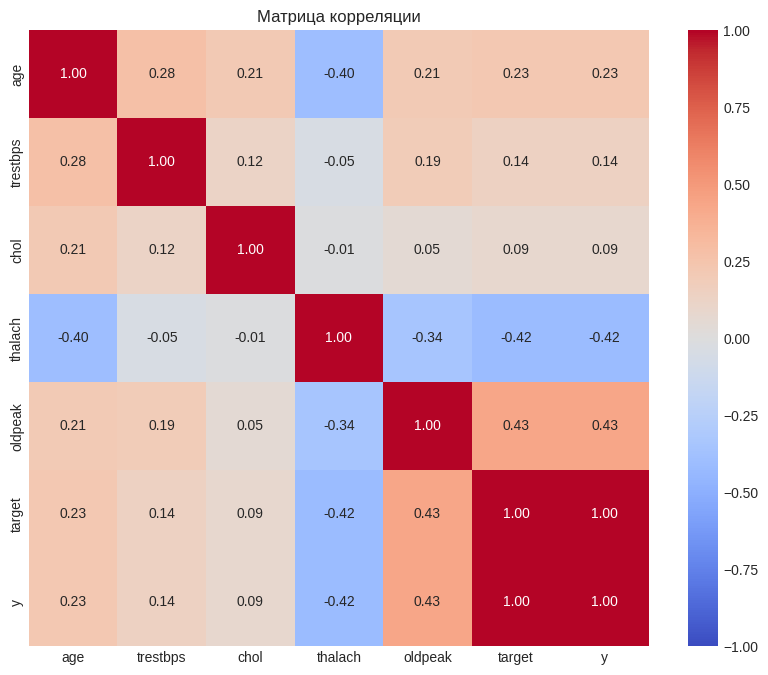

In [ ]:
# Создаём целевой признак y если его ещё нет
if 'y' not in df.columns:
    df['y'] = (df['class'] != 'H').astype(int)

# Вычисляем корреляцию для числовых признаков включая y
corr = df.select_dtypes(include=[np.number]).corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Матрица корреляции')
plt.show()

Столбец y покажет корреляцию каждого признака с целевым. Чем ближе к +1 или -1 — тем сильнее линейная связь.

Высокая корреляция между независимыми признаками (мультиколлинеарность) может привести к нестабильным оценкам коэффициентов регрессии (высокая дисперсия оценок). Это отрицательно влияет на интерпретацию коэффициентов

сделать вывод на основе графика

**7. Парные диаграммы рассеяния**

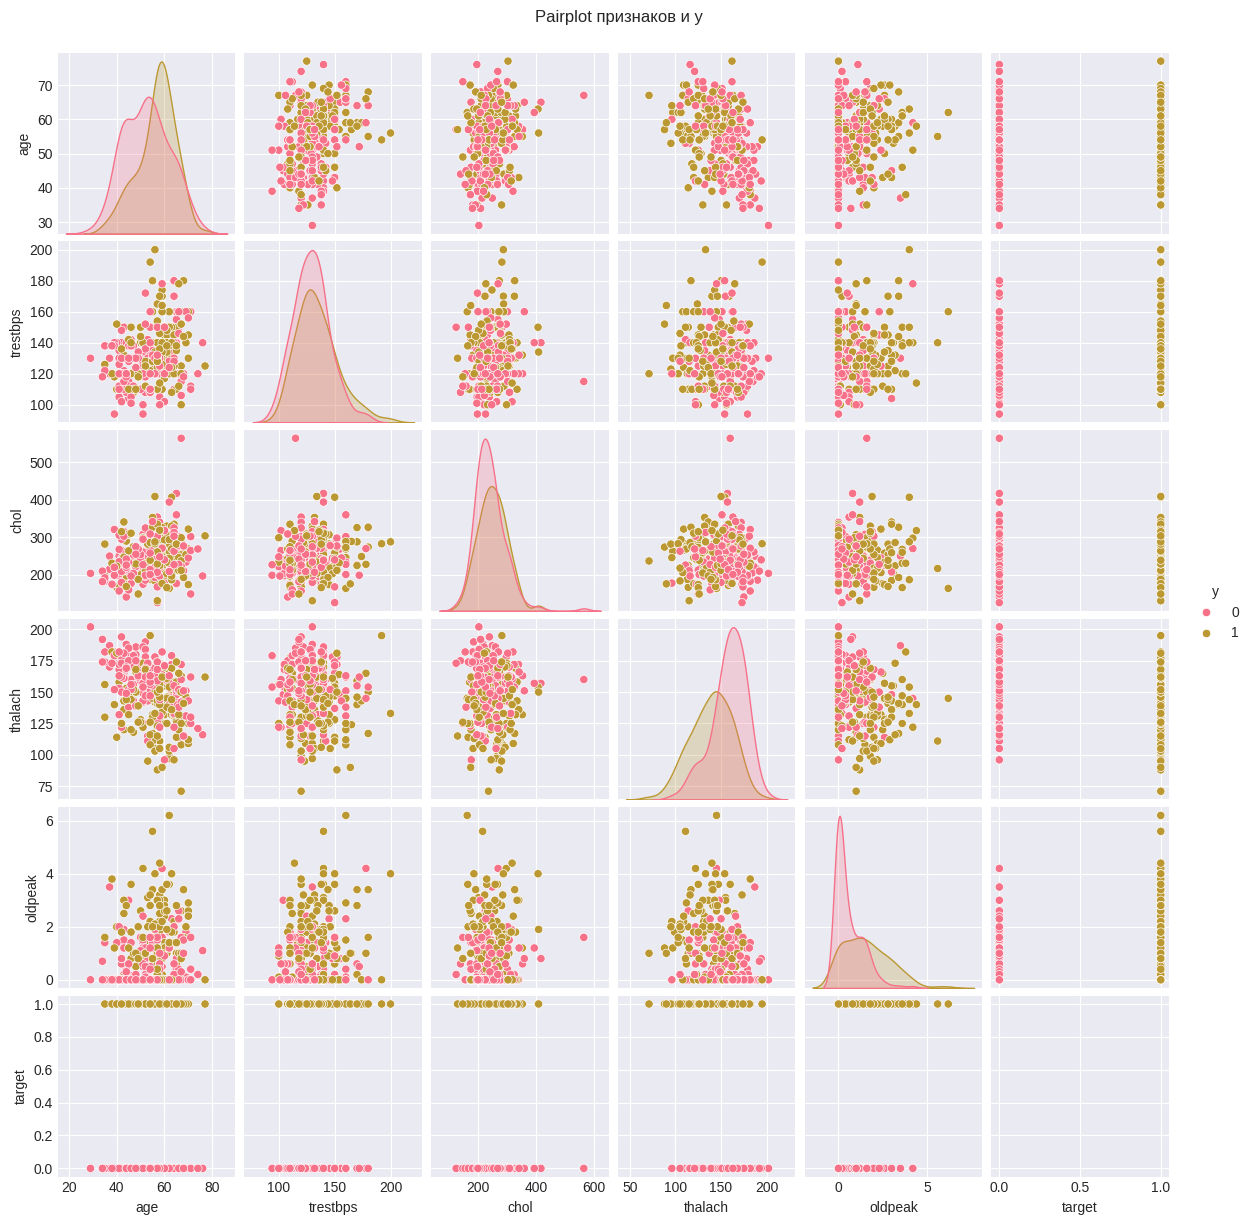

In [ ]:
# Определяем feature_names как список числовых колонок (исключая 'y')
feature_names = [col for col in df.select_dtypes(include=[np.number]).columns if col != 'y']

# pairplot для основных признаков и y
sns.pairplot(df[feature_names + ['y']], height=2.0, hue='y')
plt.suptitle('Pairplot признаков и y', y=1.02)
plt.show()

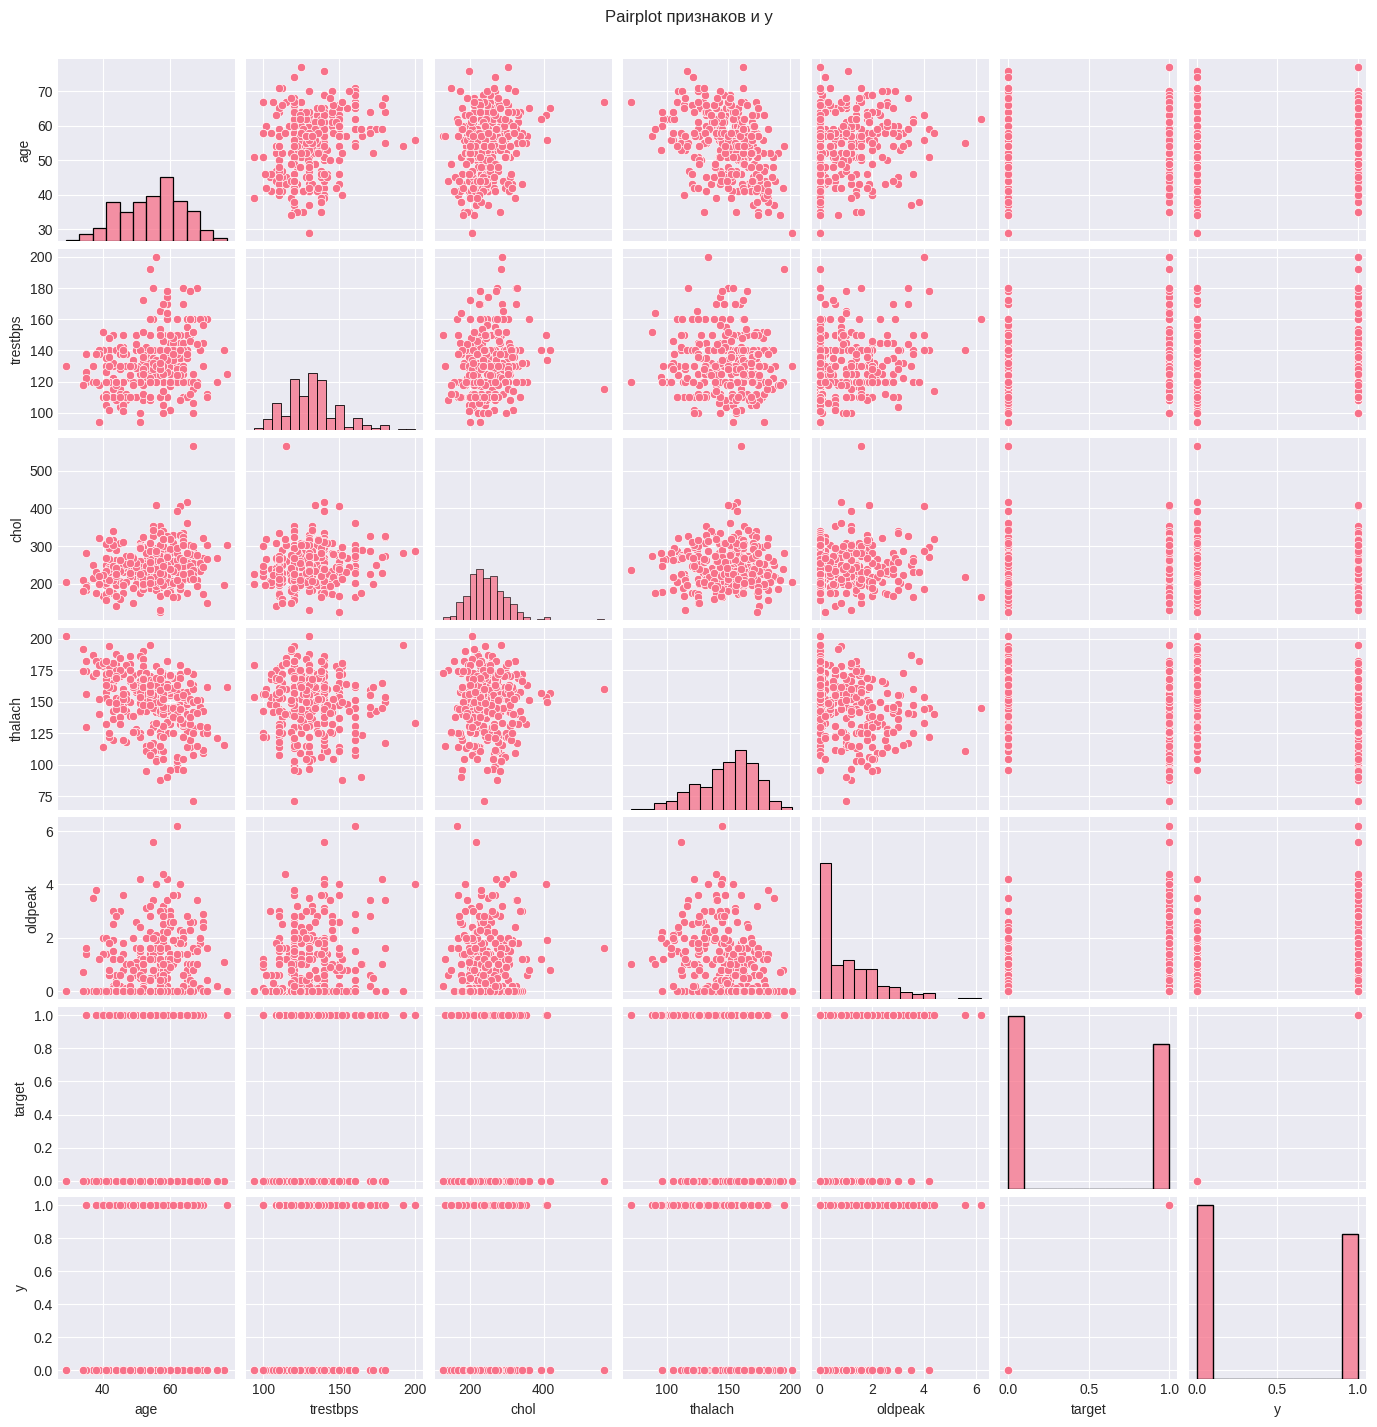

Наиболее скоррелированный признак с y: target  corr= 1.0


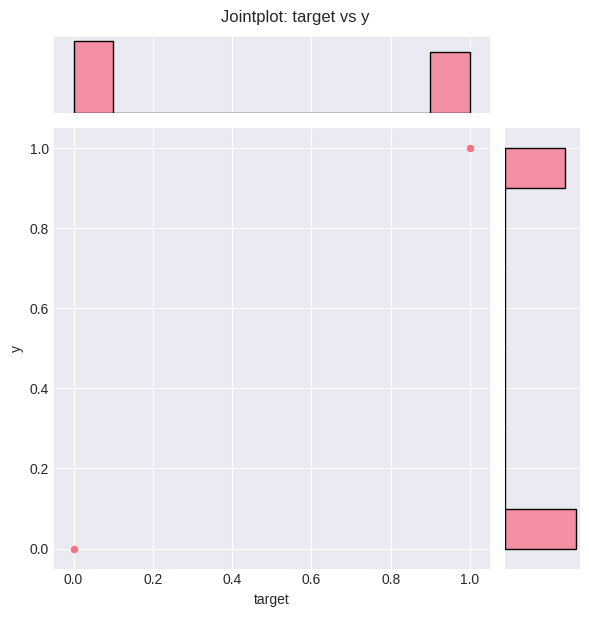

In [ ]:
# Выберем признак с наибольшей абсолютной корреляцией с y
corr_with_y = corr['y'].drop('y')
best_feature = corr_with_y.abs().idxmax()
print('Наиболее скоррелированный признак с y:', best_feature, ' corr=', corr_with_y[best_feature])


# jointplot для целевого признака vs лучшего признака
sns.jointplot(x=df[best_feature], y=df['y'], kind='scatter', height=6)
plt.suptitle(f'Jointplot: {best_feature} vs y', y=1.02)
plt.show()

**8. Plotly — 2D и 3D диаграммы рассеяния**

In [ ]:
# Выбираем два наиболее значимых признака по абсолютной корреляции
top2 = corr_with_y.abs().sort_values(ascending=False).head(2).index.tolist()
feature_a, feature_b = top2[0], top2[1]
print('Топ-2 признака:', feature_a, feature_b)

# Подготовим датафрейм для визуализации
df_viz = df.copy()
df_viz['target'] = (df_viz['class'] != 'H').astype(int)
df_viz['target_label'] = df_viz['class'].apply(lambda x: 'Здоров' if x == 'H' else 'Болен')

# 2D: feature vs target (с небольшим смещением по оси y для видимости)
fig2d = px.strip(df_viz, x=feature_a, y='target_label', color='target_label',
                 hover_data=numeric_features, title=f'2D: {feature_a} vs target', height=600,
                 color_discrete_map={'Здоров':'green','Болен':'red'})
fig2d.update_traces(jitter=0.3, marker={'opacity':0.7})
fig2d.show()

# 3D: feature_a, feature_b, thalach
fig3d = px.scatter_3d(df_viz, x=feature_a, y=feature_b, z='thalach', color='target_label',
                       hover_data=numeric_features, title=f'3D: {feature_a}, {feature_b}, thalach',
                       color_discrete_map={'Здоров':'green','Болен':'red'}, height=700)
fig3d.show()

Топ-2 признака: target oldpeak


**Построение модели линейной регрессии и оценка качества**

In [ ]:
# Подготовка переменной `corr_with_y` для совместимости старых ячеек
# Корреляция числовых признаков с бинарной целью (0=H, 1=S*)
numeric_features = df.select_dtypes(include=[np.number]).columns.tolist()
# убираем целевые, если попали
numeric_features = [c for c in numeric_features if c != 'target']

corr_with_y = df[numeric_features].corrwith((df['class'] != 'H').astype(int))
print('corr_with_y computed:')
print(corr_with_y.sort_values(ascending=False).round(4))